In [1]:
#增加交叉特征
#Score: Score: 0.89048
#使用5折交叉验证,增加scale_pos_weight参数
#Score: Score: 0.89292
#增加G/L
#Score: 0.88696
#交叉特征增加location_type，不使用G/L
#Score: 0.88777
#增加incident_location_type、incident_location_street、policy_bind_date_year&auto_year_diff、incident_date_year&auto_year_diff、duration、出险情况2、出险车信息
#Score: 0.88804
#使用insured_zip，训练使用earlystop，LGBM
#Score: 0.89861
#使用insured_zip, 7折lgbm
#Score: 0.88845
#调整'colsample_bytree': 0.8，7折lgbm
#Score:0.88370

#lgbm
#train、test合并一起做QuantileTransformer变换
#Score: 0.89997
#train、test不合并做QuantileTransformer变换，先做train的fit_trans，在做test的trans
#Score: 0.89428

#K折lgbm
#做QuantileTransformer变换
#Score: 0.88370
#'colsample_bytree': 1
#Score: 0.89712
#train、test不合并做QuantileTransformer变换，先做train的fit_trans，在做test的trans
#Score: 0.88899

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [3]:
#数据加载
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [4]:
datas = pd.concat((train_data, test_data))
datas.reset_index(drop=True, inplace=True)

## 数据探索

In [5]:
cat_columns = datas.select_dtypes(include=['O']).columns
numerical_columns = datas.select_dtypes(exclude=['O']).columns

In [6]:
col_name = []
unique_value = []
for col in cat_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_cat_col_unique = pd.DataFrame()
df_cat_col_unique['col_name'] = col_name
df_cat_col_unique['unique_value'] = unique_value
df_cat_col_unique = df_cat_col_unique.sort_values('unique_value', ascending= False)
# df_cat_col_unique

In [7]:
col_name = []
unique_value = []
for col in numerical_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_numerical_col_unique = pd.DataFrame()
df_numerical_col_unique['col_name'] = col_name
df_numerical_col_unique['unique_value'] = unique_value
df_numerical_col_unique = df_numerical_col_unique.sort_values('unique_value', ascending= False)
# df_numerical_col_unique

In [8]:
# df_cat_col_unique
df_numerical_col_unique

,col_name,unique_value
2,policy_number,1000
6,insured_zip,995
4,policy_annual_premium,991
13,total_claim_amount,763
16,vehicle_claim,726
14,injury_claim,638
15,property_claim,626
0,months_as_customer,391
8,capital-loss,354
7,capital-gains,338


## 特征工程

#### 标签编码 policy_bind_date、incident_date

In [9]:
datas['policy_bind_date'] = pd.to_datetime(datas['policy_bind_date'])
datas['incident_date'] = pd.to_datetime(datas['incident_date'])

In [10]:
#时间多尺度
datas['policy_bind_date_year'] = datas['policy_bind_date'].dt.year
datas['policy_bind_date_month'] = datas['policy_bind_date'].dt.month
datas['policy_bind_date_day'] = datas['policy_bind_date'].dt.day
datas['policy_bind_date_weekday'] = datas['policy_bind_date'].dt.weekday

datas['incident_date_year'] = datas['incident_date'].dt.year
datas['incident_date_month'] = datas['incident_date'].dt.month
datas['incident_date_day'] = datas['incident_date'].dt.day
datas['incident_date_weekday'] = datas['incident_date'].dt.weekday

In [11]:
# 查看最小、最大日期
# datas.policy_bind_date.min() #1990-01-08
# datas.policy_bind_date.max() #2015-02-22

# datas.incident_date.min() #2015-01-01
# datas.incident_date.max() #2015-03-01

In [12]:
base_date = datas.policy_bind_date.min()
#转换为diff
datas['policy_bind_date_diff'] = (datas['policy_bind_date'] - base_date).dt.days
datas['incident_date_diff'] = (datas['incident_date'] - base_date).dt.days
datas['incident_date&policy_bind_date_diff'] = datas['incident_date_diff'] - datas['policy_bind_date_diff']

#### 构造交叉业务特征

In [13]:
datas['injury_claim_pct'] = datas['injury_claim']/datas['total_claim_amount']
datas['property_claim_pct'] = datas['property_claim']/datas['total_claim_amount']
datas['vehicle_claim_pct'] = datas['vehicle_claim']/datas['total_claim_amount']

In [14]:
datas['is_injury_claim'] = datas['injury_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_property_claim'] = datas['property_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_vehicle_claim'] = datas['vehicle_claim'].apply(lambda x: '1' if x >0 else '0')

In [15]:
#出险情况1
datas['incident_type_&_is_injury_claim'] = datas['incident_type'] + '_' + datas['is_injury_claim']
datas['incident_type_&_is_property_claim'] = datas['incident_type'] + '_' + datas['is_property_claim']
datas['incident_type_&_is_vehicle_claim'] = datas['incident_type'] + '_' + datas['is_vehicle_claim']

datas['collision_type_&_is_injury_claim'] = datas['collision_type'] + '_' + datas['is_injury_claim']
datas['collision_type_&_is_property_claim'] = datas['collision_type'] + '_' + datas['is_property_claim']
datas['collision_type_&_is_vehicle_claim'] = datas['collision_type'] + '_' + datas['is_vehicle_claim']

In [16]:
datas['umbrella_limit_2_total_claim_amount'] = datas['umbrella_limit']/datas['total_claim_amount']

In [17]:
# datas['G/L'] = datas['capital-gains'] + datas['capital-loss']

In [18]:
datas['incident_location_type'] = datas['incident_location'].apply(lambda x: x.split()[-1])
datas['incident_location_street'] = datas['incident_location'].apply(lambda x: ' '.join(x.split()[-2:]))

In [19]:
#购车年份与投保年份之差
datas['policy_bind_date_year&auto_year_diff'] = datas['policy_bind_date_year'] - datas['auto_year']

#购车年份与出险年份之差
datas['incident_date_year&auto_year_diff'] = datas['incident_date_year'] - datas['auto_year']

#成为客户的时长与购报后出险时长之差
datas['duration'] = round((datas['incident_date'] - datas['policy_bind_date']).dt.days/30) - datas['months_as_customer']

In [20]:
#出险情况2
datas['incident_type&collision_type'] = (datas['incident_type'] + "_" + datas['collision_type'])

datas['incident_type&incident_severity'] = (datas['incident_type'] + "_" + datas['incident_severity'])
datas['collision_type&incident_severity'] = (datas['collision_type'] + "_" + datas['incident_severity'])

datas['incident_type&bodily_injuries'] = (datas['incident_type'] + "_" + datas['bodily_injuries'].apply(lambda x : str(x)))
datas['collision_type&bodily_injuries'] = (datas['collision_type'] + "_" + datas['bodily_injuries'].apply(lambda x : str(x)))

datas['incident_type&property_damage'] = (datas['incident_type'] + "_" + datas['property_damage'])
datas['collision_type&property_damage'] = (datas['collision_type'] + "_" + datas['property_damage'])

datas['incident_type&collision_type&incident_severity&bodily_injuries&property_damage'] = (datas['incident_type'] + "_" + datas['collision_type'] + "_" + datas['incident_severity'] 
 + "_" + datas['bodily_injuries'].apply(lambda x : str(x)) + "_" + datas['property_damage'])

In [21]:
#出险车信息
datas['auto_make&auto_model'] = datas['auto_make'] + "_" + datas['auto_model']

In [22]:
# datas[['incident_type', 'collision_type', 'bodily_injuries', 'incident_severity', 'property_damage', 'policy_csl', 'policy_annual_premium', 'umbrella_limit', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'capital-gains', 'capital-loss']][datas['fraud_reported'] > 0]

In [23]:
#检查单个特征
# datas.property_damage.nunique()
# datas['property_damage'].value_counts()

In [24]:
datas.drop(['policy_bind_date', 'incident_date', '_c39', 'incident_location', 'policy_number', 'auto_make', 'auto_model'], axis= 1, inplace=True)
#下次保留insured_zip试试

In [25]:
numerical_columns = datas.select_dtypes(exclude=['O']).columns
cat_columns = datas.select_dtypes(include=['O']).columns

In [26]:
numerical_columns = numerical_columns.delete(numerical_columns.get_loc('fraud_reported'))

In [27]:
import math

In [28]:
df_melted = pd.melt(datas[numerical_columns].join(pd.DataFrame(['Train' if not math.isnan(label) else 'Test' 
                                                                for label in datas['fraud_reported']], index=datas.index, columns=['Source'])
                                                  , how='left'), id_vars= ['Source'],
                    )

In [29]:
numerical_columns

Index(['months_as_customer', 'age', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip',
       'capital-gains', 'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year', 'policy_bind_date_year', 'policy_bind_date_month',
       'policy_bind_date_day', 'policy_bind_date_weekday',
       'incident_date_year', 'incident_date_month', 'incident_date_day',
       'incident_date_weekday', 'policy_bind_date_diff', 'incident_date_diff',
       'incident_date&policy_bind_date_diff', 'injury_claim_pct',
       'property_claim_pct', 'vehicle_claim_pct',
       'umbrella_limit_2_total_claim_amount',
       'policy_bind_date_year&auto_year_diff',
       'incident_date_year&auto_year_diff', 'duration'],
      dtype='object')

<AxesSubplot:xlabel='capital-gains', ylabel='Density'>

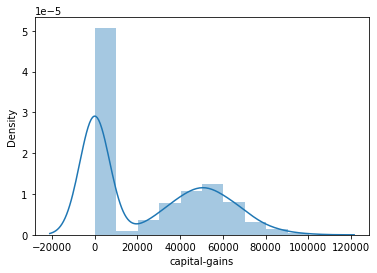

In [30]:
sns.distplot(datas['capital-gains'])

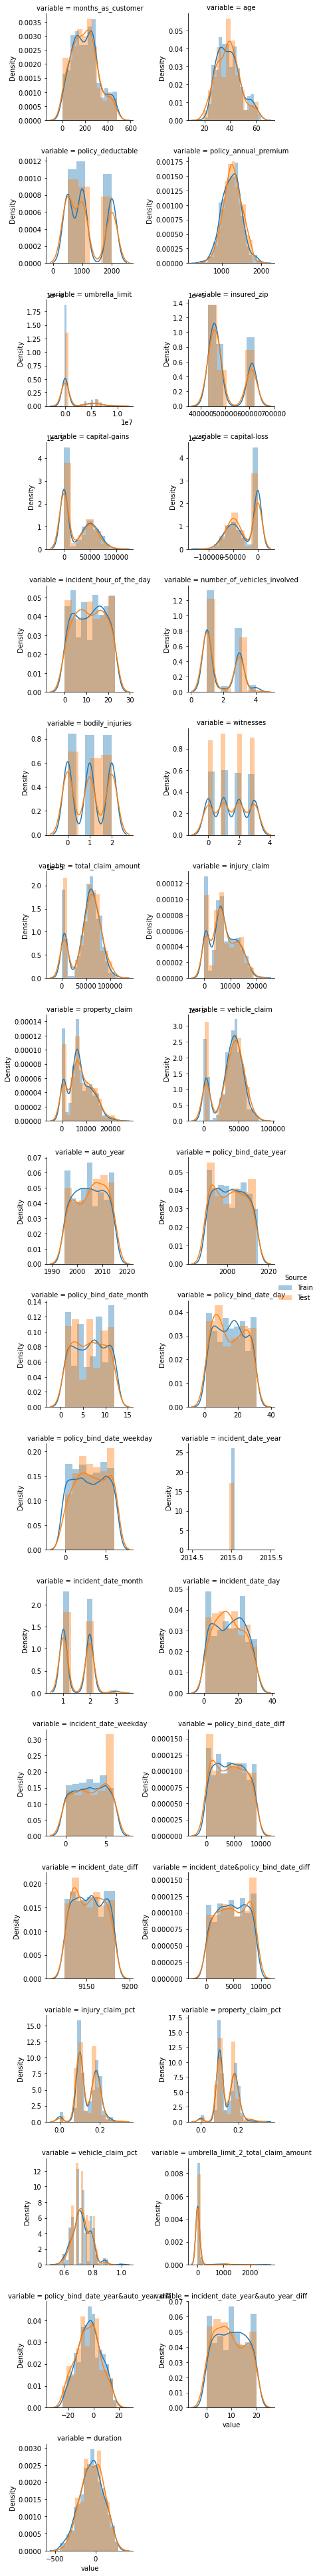

In [31]:
#画出各特征的分布图

g = sns.FacetGrid(df_melted, hue = 'Source', col='variable', col_wrap= 2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.add_legend()

In [32]:
from sklearn.preprocessing import QuantileTransformer

In [33]:
# 数据集切分
train = datas[datas['fraud_reported'].notnull()]
test = datas[datas['fraud_reported'].isnull()]

In [34]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state = 2022)
# datas[numerical_columns] = quantile_transformer.fit_transform(datas[numerical_columns])
train[numerical_columns] = quantile_transformer.fit_transform(train[numerical_columns])
test[numerical_columns] = quantile_transformer.transform(test[numerical_columns])

In [35]:
datas = pd.concat((train, test))
datas.reset_index(drop=True, inplace=True)

In [36]:
df_melted = pd.melt(datas[numerical_columns].join(pd.DataFrame(['Train' if not math.isnan(label) else 'Test' 
                                                                for label in datas['fraud_reported']], index=datas.index, columns=['Source'])
                                                  , how='left'), id_vars= ['Source'],
                    )

<AxesSubplot:xlabel='capital-gains', ylabel='Density'>

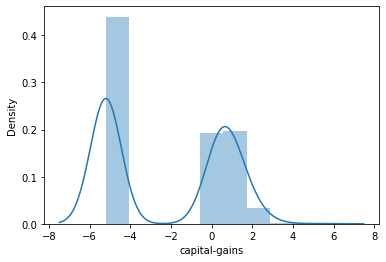

In [37]:
sns.distplot(datas['capital-gains'])

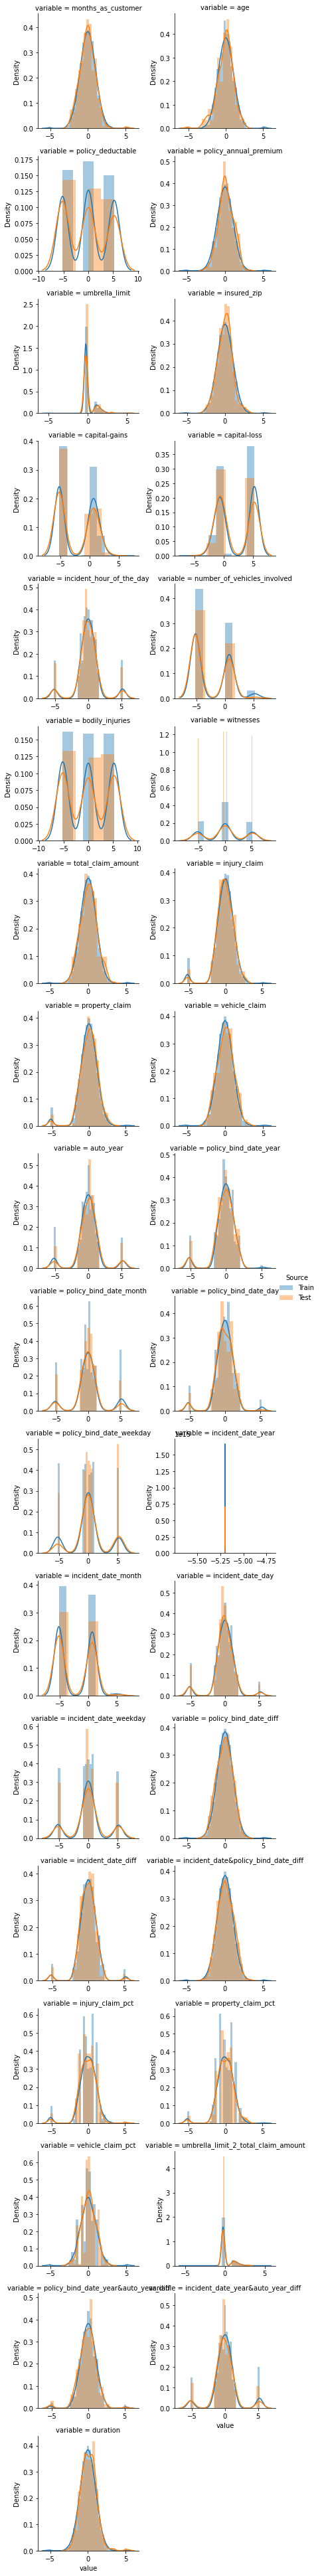

In [38]:
#画出各特征的分布图

g = sns.FacetGrid(df_melted, hue = 'Source', col='variable', col_wrap= 2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.add_legend()

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
cat_columns = datas.select_dtypes(include= ['O']).columns

In [41]:
for col in cat_columns:
    le = LabelEncoder()
    datas[col] = le.fit_transform(datas[col])

datas[cat_columns]

,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,...,incident_location_street,incident_type&collision_type,incident_type&incident_severity,collision_type&incident_severity,incident_type&bodily_injuries,collision_type&bodily_injuries,incident_type&property_damage,collision_type&property_damage,incident_type&collision_type&incident_severity&bodily_injuries&property_damage,auto_make&auto_model
0,1,2,0,5,10,15,1,2,3,2,...,106,6,7,10,6,9,6,9,170,25
1,0,1,1,3,2,14,2,0,3,1,...,144,2,1,9,2,11,0,9,69,19
2,0,2,0,2,6,16,5,2,3,2,...,78,6,7,10,8,11,6,9,176,21
3,2,2,1,3,13,18,3,0,1,0,...,144,0,0,2,2,5,2,5,8,33
4,2,0,0,4,2,18,3,0,2,2,...,18,1,2,7,2,8,2,8,53,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,0,1,9,11,1,1,0,3,...,125,3,4,1,3,0,4,1,91,12
996,1,1,1,4,0,12,4,0,3,2,...,73,2,2,10,0,9,0,9,72,20
997,1,2,0,0,7,10,1,2,2,1,...,78,5,6,6,6,6,8,8,136,13
998,1,0,0,4,10,10,4,0,3,1,...,100,2,1,9,2,11,2,11,71,25


In [42]:
# 数据集切分
train = datas[datas['fraud_reported'].notnull()]
test = datas[datas['fraud_reported'].isnull()]

In [43]:
train_X = train.drop(['fraud_reported'], axis=1)
train_y = train['fraud_reported']
test_X = test.drop(['fraud_reported'], axis=1)

In [44]:
#增加检验
train_X2,eval_X,train_y2,eval_y = train_test_split(train_X, train_y, test_size=0.2, random_state=2022, stratify=train_y)

## 使用lgbm 训练

In [45]:
import lightgbm as lgb

In [46]:
model_lgb = lgb.LGBMClassifier(
            num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='binary', metric = 'binary_logloss,auc',
            max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2022,
            n_estimators=2000, subsample=1, colsample_bytree=1,
        )

In [47]:
model_lgb.fit(train_X2, train_y2, eval_set=(eval_X, eval_y), #categorical_feature = cat_columns.values.tolist(),
              early_stopping_rounds = 400)

[1]	valid_0's binary_logloss: 0.567865	valid_0's auc: 0.830262
Training until validation scores don't improve for 400 rounds
[2]	valid_0's binary_logloss: 0.565782	valid_0's auc: 0.825721
[3]	valid_0's binary_logloss: 0.563679	valid_0's auc: 0.826255
[4]	valid_0's binary_logloss: 0.561609	valid_0's auc: 0.826255
[5]	valid_0's binary_logloss: 0.559624	valid_0's auc: 0.825988
[6]	valid_0's binary_logloss: 0.557599	valid_0's auc: 0.826255
[7]	valid_0's binary_logloss: 0.555658	valid_0's auc: 0.826255
[8]	valid_0's binary_logloss: 0.553799	valid_0's auc: 0.826255
[9]	valid_0's binary_logloss: 0.552045	valid_0's auc: 0.825988
[10]	valid_0's binary_logloss: 0.550317	valid_0's auc: 0.825988
[11]	valid_0's binary_logloss: 0.548687	valid_0's auc: 0.825988
[12]	valid_0's binary_logloss: 0.546826	valid_0's auc: 0.826122
[13]	valid_0's binary_logloss: 0.545124	valid_0's auc: 0.821448
[14]	valid_0's binary_logloss: 0.54346	valid_0's auc: 0.821581
[15]	valid_0's binary_logloss: 0.541781	valid_0's au

[166]	valid_0's binary_logloss: 0.421281	valid_0's auc: 0.838542
[167]	valid_0's binary_logloss: 0.420986	valid_0's auc: 0.838542
[168]	valid_0's binary_logloss: 0.420666	valid_0's auc: 0.838809
[169]	valid_0's binary_logloss: 0.420371	valid_0's auc: 0.83961
[170]	valid_0's binary_logloss: 0.420096	valid_0's auc: 0.83961
[171]	valid_0's binary_logloss: 0.419982	valid_0's auc: 0.839343
[172]	valid_0's binary_logloss: 0.419615	valid_0's auc: 0.83961
[173]	valid_0's binary_logloss: 0.419332	valid_0's auc: 0.839877
[174]	valid_0's binary_logloss: 0.418981	valid_0's auc: 0.83961
[175]	valid_0's binary_logloss: 0.418689	valid_0's auc: 0.840144
[176]	valid_0's binary_logloss: 0.418352	valid_0's auc: 0.840411
[177]	valid_0's binary_logloss: 0.418268	valid_0's auc: 0.840678
[178]	valid_0's binary_logloss: 0.417887	valid_0's auc: 0.840678
[179]	valid_0's binary_logloss: 0.417557	valid_0's auc: 0.841213
[180]	valid_0's binary_logloss: 0.417266	valid_0's auc: 0.84148
[181]	valid_0's binary_logloss

[327]	valid_0's binary_logloss: 0.39708	valid_0's auc: 0.85617
[328]	valid_0's binary_logloss: 0.397042	valid_0's auc: 0.85617
[329]	valid_0's binary_logloss: 0.397047	valid_0's auc: 0.855903
[330]	valid_0's binary_logloss: 0.39701	valid_0's auc: 0.855903
[331]	valid_0's binary_logloss: 0.396999	valid_0's auc: 0.855636
[332]	valid_0's binary_logloss: 0.396867	valid_0's auc: 0.855369
[333]	valid_0's binary_logloss: 0.396866	valid_0's auc: 0.85617
[334]	valid_0's binary_logloss: 0.396715	valid_0's auc: 0.85617
[335]	valid_0's binary_logloss: 0.396727	valid_0's auc: 0.855369
[336]	valid_0's binary_logloss: 0.396615	valid_0's auc: 0.85617
[337]	valid_0's binary_logloss: 0.396636	valid_0's auc: 0.855636
[338]	valid_0's binary_logloss: 0.396707	valid_0's auc: 0.855636
[339]	valid_0's binary_logloss: 0.396783	valid_0's auc: 0.855101
[340]	valid_0's binary_logloss: 0.396731	valid_0's auc: 0.855369
[341]	valid_0's binary_logloss: 0.396613	valid_0's auc: 0.855101
[342]	valid_0's binary_logloss: 

[488]	valid_0's binary_logloss: 0.400488	valid_0's auc: 0.849092
[489]	valid_0's binary_logloss: 0.400454	valid_0's auc: 0.849626
[490]	valid_0's binary_logloss: 0.400495	valid_0's auc: 0.849626
[491]	valid_0's binary_logloss: 0.400545	valid_0's auc: 0.849359
[492]	valid_0's binary_logloss: 0.40056	valid_0's auc: 0.848825
[493]	valid_0's binary_logloss: 0.400623	valid_0's auc: 0.848825
[494]	valid_0's binary_logloss: 0.400679	valid_0's auc: 0.848825
[495]	valid_0's binary_logloss: 0.40082	valid_0's auc: 0.849092
[496]	valid_0's binary_logloss: 0.400878	valid_0's auc: 0.849359
[497]	valid_0's binary_logloss: 0.400966	valid_0's auc: 0.849092
[498]	valid_0's binary_logloss: 0.401049	valid_0's auc: 0.849092
[499]	valid_0's binary_logloss: 0.40104	valid_0's auc: 0.849626
[500]	valid_0's binary_logloss: 0.401195	valid_0's auc: 0.849626
[501]	valid_0's binary_logloss: 0.401303	valid_0's auc: 0.849893
[502]	valid_0's binary_logloss: 0.4014	valid_0's auc: 0.849893
[503]	valid_0's binary_logloss

[620]	valid_0's binary_logloss: 0.409056	valid_0's auc: 0.844284
[621]	valid_0's binary_logloss: 0.409163	valid_0's auc: 0.844551
[622]	valid_0's binary_logloss: 0.409232	valid_0's auc: 0.844284
[623]	valid_0's binary_logloss: 0.409309	valid_0's auc: 0.844017
[624]	valid_0's binary_logloss: 0.409234	valid_0's auc: 0.844017
[625]	valid_0's binary_logloss: 0.409287	valid_0's auc: 0.84375
[626]	valid_0's binary_logloss: 0.409454	valid_0's auc: 0.844017
[627]	valid_0's binary_logloss: 0.409624	valid_0's auc: 0.84375
[628]	valid_0's binary_logloss: 0.409648	valid_0's auc: 0.844017
[629]	valid_0's binary_logloss: 0.409822	valid_0's auc: 0.84375
[630]	valid_0's binary_logloss: 0.410016	valid_0's auc: 0.843216
[631]	valid_0's binary_logloss: 0.410067	valid_0's auc: 0.842682
[632]	valid_0's binary_logloss: 0.41014	valid_0's auc: 0.843483
[633]	valid_0's binary_logloss: 0.410191	valid_0's auc: 0.843483
[634]	valid_0's binary_logloss: 0.410267	valid_0's auc: 0.84375
[635]	valid_0's binary_logloss

LGBMClassifier(colsample_bytree=1, learning_rate=0.005,
               metric='binary_logloss,auc', min_child_samples=3,
               n_estimators=2000, objective='binary', random_state=2022,
               reg_alpha=0.25, reg_lambda=0.25, subsample=1)

In [48]:
y_pred = model_lgb.predict_proba(test_X )[:, 1]

#检验
# y_pred = model_lgb.predict_proba(eval_X)[:, 1]

In [49]:
y_pred

array([0.07761928, 0.60730552, 0.06084415, 0.28776503, 0.05908031,
       0.06289974, 0.06010396, 0.07213577, 0.05908031, 0.11592563,
       0.47620755, 0.05932338, 0.6774583 , 0.07514912, 0.08475583,
       0.46637705, 0.07761928, 0.07359258, 0.79414146, 0.0609839 ,
       0.06549398, 0.12929735, 0.39238684, 0.07471731, 0.08111772,
       0.62006814, 0.06540585, 0.07917583, 0.40968896, 0.07788732,
       0.26877437, 0.07529506, 0.34096975, 0.05908031, 0.07123236,
       0.06350886, 0.72276357, 0.11969931, 0.06684407, 0.07239378,
       0.64792237, 0.12202493, 0.11936609, 0.05908031, 0.05925951,
       0.0701601 , 0.06851937, 0.06840263, 0.72245989, 0.05908031,
       0.06289974, 0.09104455, 0.05908031, 0.24778573, 0.77498187,
       0.06448326, 0.1970271 , 0.26193741, 0.06695996, 0.44032702,
       0.06851937, 0.05908031, 0.05975391, 0.55624849, 0.05908031,
       0.05908031, 0.78866226, 0.52907507, 0.13244421, 0.06289974,
       0.0836308 , 0.07761258, 0.42710366, 0.82880827, 0.08693

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

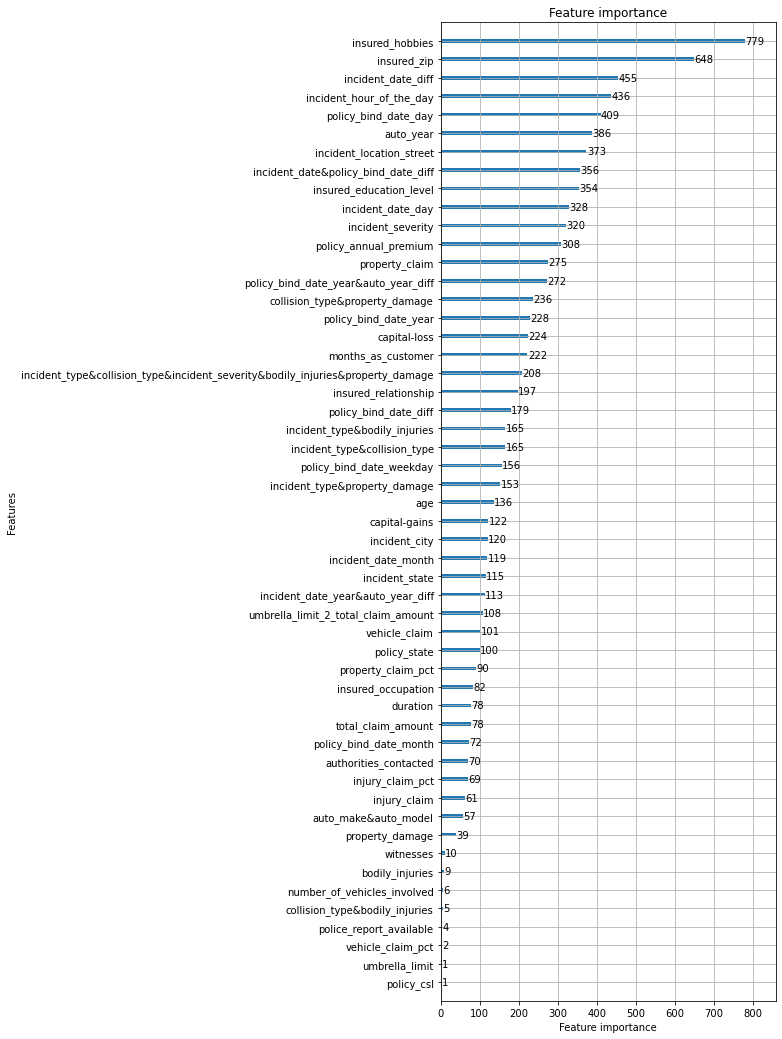

In [50]:
fig, ax = plt.subplots(figsize=(6,18))
lgb.plot_importance(model_lgb, max_num_features=70, ax = ax)

In [51]:
#检验
# roc_auc_score(eval_y, y_pred)

In [52]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission.csv', index=None)

## 使用五折交叉验证的LightGBM

In [53]:
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb

In [54]:
params_lgb = {
    'num_leaves': 2**5-1, 'reg_alpha': 0.25, 'reg_lambda': 0.25, 'objective': 'binary', 'metric': 'binary_logloss,auc',
    'max_depth': -1, 'learning_rate': 0.001, 'min_child_samples': 3, 'random_state': 2022,
    #'n_estimators': 2000, 
    'subsample': 1, 'colsample_bytree': 1, #'scale_pos_weight': 3
}

In [55]:
NFOLD = 7

In [56]:
kf = StratifiedKFold(n_splits = NFOLD, shuffle = True, random_state = 2022)

y_pred = np.zeros(len(test_X))

#检验
# y_pred = np.zeros(len(eval_X))

In [57]:
mean_valscore = []
for fold, (train_index, val_index) in enumerate(kf.split(train_X, train_y)):
    X_fold_train, X_fold_val = train_X.iloc[train_index, :], train_X.iloc[val_index, :]
    y_fold_train, y_fold_val = train_y.iloc[train_index], train_y.iloc[val_index]
    train_set = lgb.Dataset(X_fold_train, y_fold_train)
    val_set = lgb.Dataset(X_fold_val, y_fold_val, reference=train_set)

    model_lgb = lgb.train(params_lgb, train_set, num_boost_round=2000, early_stopping_rounds=500,
                      valid_sets = val_set, verbose_eval=100)
    
    mean_valscore.append(model_lgb.best_score['valid_0']['auc'])

    y_pred += model_lgb.predict(test_X)/kf.n_splits
    
print('valscore:', mean_valscore)
print('mean_valscore:', np.mean(mean_valscore))
    
    #检验
#     y_pred += model_lgb.predict(eval_X, num_iteration=model_lgb.best_iteration)/kf.n_splits

# y_pred = [1 if y > 0.5 else 0 for y in y_pred]
# rmse = metrics.accuracy_score(y_pred,y_test)
# print(rmse)

[LightGBM] [Info] Number of positive: 156, number of negative: 444
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3136
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260000 -> initscore=-1.045969
[LightGBM] [Info] Start training from score -1.045969
Training until validation scores don't improve for 500 rounds
[100]	valid_0's binary_logloss: 0.5312	valid_0's auc: 0.843467
[200]	valid_0's binary_logloss: 0.505886	valid_0's auc: 0.8432
[300]	valid_0's binary_logloss: 0.487725	valid_0's auc: 0.84
[400]	valid_0's binary_logloss: 0.469582	valid_0's auc: 0.842667
[500]	valid_0's binary_logloss: 0.455128	valid_0's auc: 0.848
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.560495	valid_0's auc: 0.8584
[LightGBM] [Info] Number of positive:

In [58]:
#检验
# roc_auc_score(eval_y, y_pred)

In [59]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission_Kfold.csv', index=None)